In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
df=pd.read_csv('reliancetest.csv',index_col=[0])

In [35]:
df

,Open,High,Low,Close,ST,SMA,EMA,RSI,MACtab,MACsig
Time,,,,,,,,,,
2022-05-30 12:00:00,2642.85,2644.85,2642.15,2644.55,2649.199439,2648.125,2643.811132,59.043996,6.968465,8.573152
2022-05-30 12:05:00,2644.80,2644.85,2640.10,2643.05,2648.038805,2647.480,2643.709648,57.335232,6.361663,8.130854
2022-05-30 12:10:00,2643.10,2648.55,2643.10,2644.50,2648.038805,2646.985,2643.815028,58.583035,5.929420,7.690568
2022-05-30 12:15:00,2644.50,2644.50,2640.00,2642.50,2647.654020,2646.810,2643.639691,56.143953,5.363653,7.225185
2022-05-30 12:20:00,2642.50,2648.00,2640.40,2647.80,2640.270310,2645.780,2644.194399,60.801475,5.282055,6.836559
...,...,...,...,...,...,...,...,...,...,...
2022-09-05 15:05:00,2573.90,2575.00,2569.05,2571.00,2567.502941,2572.610,2571.886843,49.717466,0.587919,1.138776
2022-09-05 15:10:00,2571.10,2573.85,2570.15,2571.00,2567.595378,2572.110,2571.768598,49.717466,0.476199,1.006260
2022-09-05 15:15:00,2571.00,2571.65,2566.95,2570.00,2567.595378,2572.010,2571.532785,47.941474,0.303470,0.865702


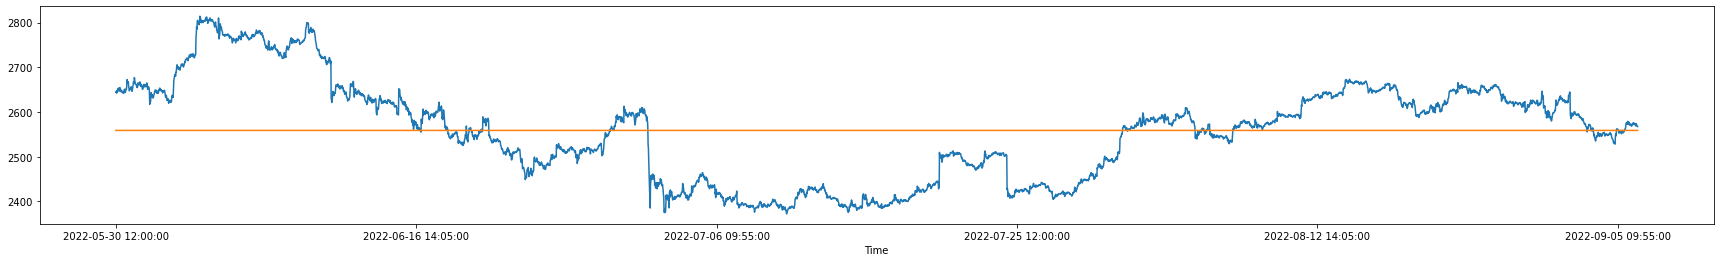

In [36]:
df['Close'].plot(figsize=(30,4))
df['mean'] = df['Close'].mean()
plt.plot(df['mean'])

In [37]:
#Check for stationary series --> ADF Test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close)
print('ADF Test Statistic: %.2f' % result[0])
print('5%% Critical Value: %.2f' % result[4]['5%'])
print('p-value: %.2f' % result[1])

ADF Test Statistic: -1.72
5% Critical Value: -2.86
p-value: 0.42


In [6]:
#As the p-value is greater than 0.05. We fail to reject the null hypothesis and conclude that the time series is not stationary

In [7]:
#Converting no-stationary time-series to stationary time-series by Differencing

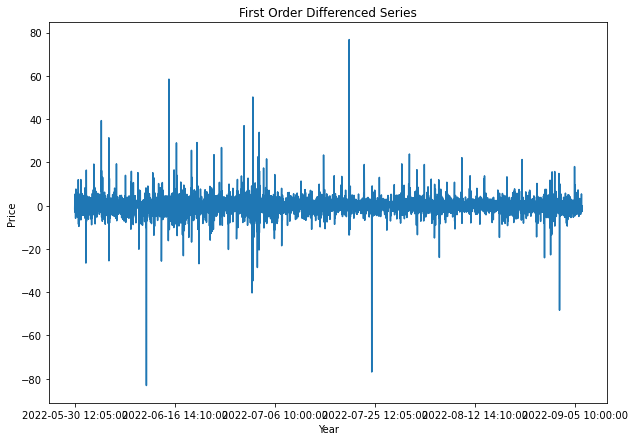

In [42]:
stationary_series = df['Close'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 7))
stationary_series.plot()
plt.title('First Order Differenced Series')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [44]:
result = adfuller(stationary_series)

if(result[1] < 0.05):
    print('The series is stationary as the p-value = %.2f <= 0.05'
          % result[1])
else:
    print('The series is not stationary as the p-value = %.2f > 0.05'
          % result[1])

The series is stationary as the p-value = 0.00 <= 0.05


In [10]:
#for ar model : three important requirements are p,q,d i,e ar model lags,differencing,ma model lags
# pacf is best to calculate ar model lags
# acf is best to calculate ma model lags
# differencing is shifting count

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

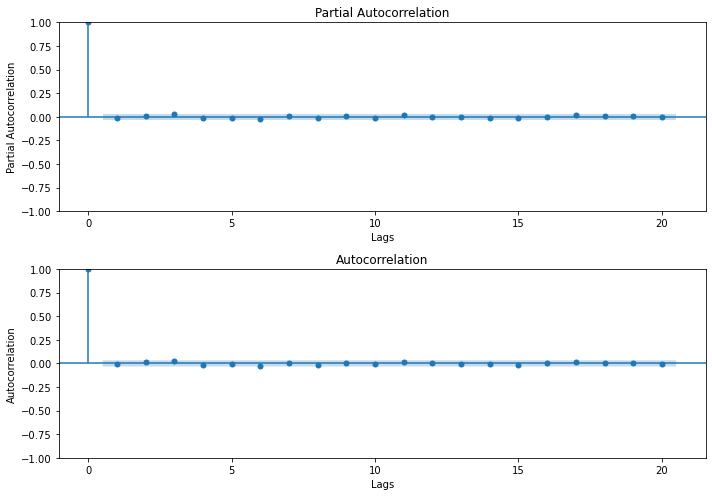

In [29]:
rolling_window = int(len(df)*0.70)
# Find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

# Plot Partial Autocorrelation Function
plot_pacf(df['Close'][:rolling_window].diff().dropna(), lags=20, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

# Plot Autocorrelation Function
plot_acf(df['Close'][:rolling_window].diff().dropna(), lags=20, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

In [22]:
# Setting the rolling window
rolling_window = int(len(df) * 0.70)

# Function to select the best model and forecast the price
def select_model_and_forecast(price_df):
    
    # The p,d and q values
    aic = []
    p = range(1, 3)
    d = range(0, 2)
    q = range(1, 3)

    # Empty list to store p,q,dist
    p_q_d = []

    # Get the aic score for different values of p, d and q
    for i in p:
        for j in d:
            for k in q:
                # Try to fit the model
                try:
                    gm = ARIMA(price_df, order=(i, j, k))
                    gm_fit = gm.fit(disp=0)
                    
                    # Calculate the AIC score
                    aic_temp = gm_fit.aic
                    keys_temp = (i, j, k)
                    
                    # Save the AIC score and the p, d and q values
                    p_q_d.append(keys_temp)
                    aic.append(aic_temp)
                except:
                    # Do nothing when the model does not fit
                    pass

    # Store values in dictionary
    aic_dict = {'p_q_d': p_q_d, 'aic': aic}

    # Create DataFrame from dictionary
    df = pd.DataFrame(aic_dict)

    # Get the minimum AIC value with the p,d and q values
    df = df[df['aic'] == df['aic'].min()].reset_index()

    # Only predict the price if the ARIMA model could be fit
    if len(df) > 0:
        # Fitting the optimum model
        gm = ARIMA(price_df, order=df.p_q_d[0])
        gm_fit = gm.fit(disp=0)
        
        # making the forecast
        predicted_price = gm_fit.forecast()[0][0]
        return predicted_price
    else:
        # Return -1 if the model could not be fit
        return -1

In [14]:
#for AR Model lags we need to check for shut off i.e sudden changes in PACF.
# for MA Model lags we need to check for exponential dexrease.
p=1
d=0
q=1

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)

# Fit ARIMA model
df['predicted'] = df['Close'].rolling(rolling_window).apply(select_model_and_forecast)

In [16]:
df.shape

(5067, 12)

In [17]:
pred_start_date = df.index[0]
pred_end_date = df.index[2000]
print("Start Date For Predictions = ",pred_start_date)
print("End Date For Predictions = ",pred_end_date)

Start Date For Predictions =  2022-05-30 12:00:00
End Date For Predictions =  2022-07-06 09:55:00


<AxesSubplot:xlabel='Time'>

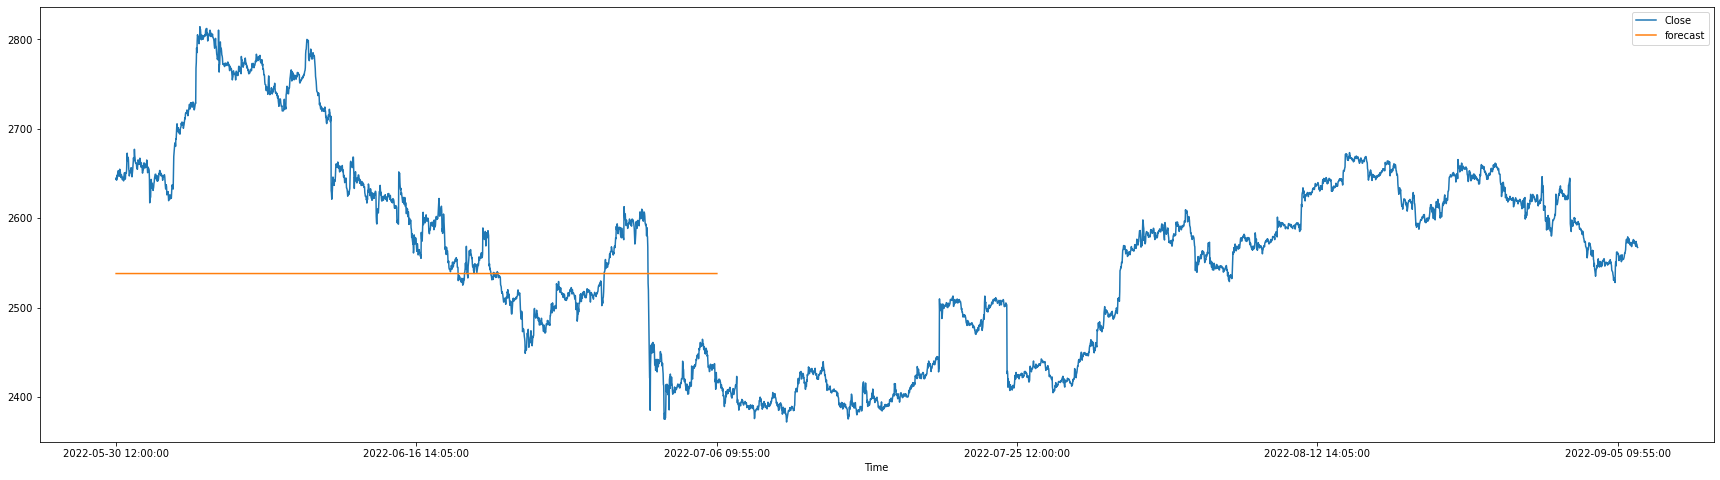

In [18]:
df['forecast']=model_fit.predict(start=pred_start_date,end=pred_end_date,dynamic=True)
df['forecast']=df['forecast'].shift(1)
df[['Close','forecast']].plot(figsize=(30,8))

In [19]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Close'],order=(1, 0, 1),seasonal_order=(1,0,1,12))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47772D+00    |proj g|=  9.53054D-01


 This problem is unconstrained.



At iterate    5    f=  3.01818D+00    |proj g|=  4.66840D-01
  ys=-1.184E-02  -gs= 1.970E-01 BFGS update SKIPPED

At iterate   10    f=  3.01501D+00    |proj g|=  4.41600D-01
  ys=-4.132E-04  -gs= 1.121E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     86      2     2     0   1.229D+00   3.015D+00
  F =   3.0149325398452289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


<AxesSubplot:xlabel='Time'>

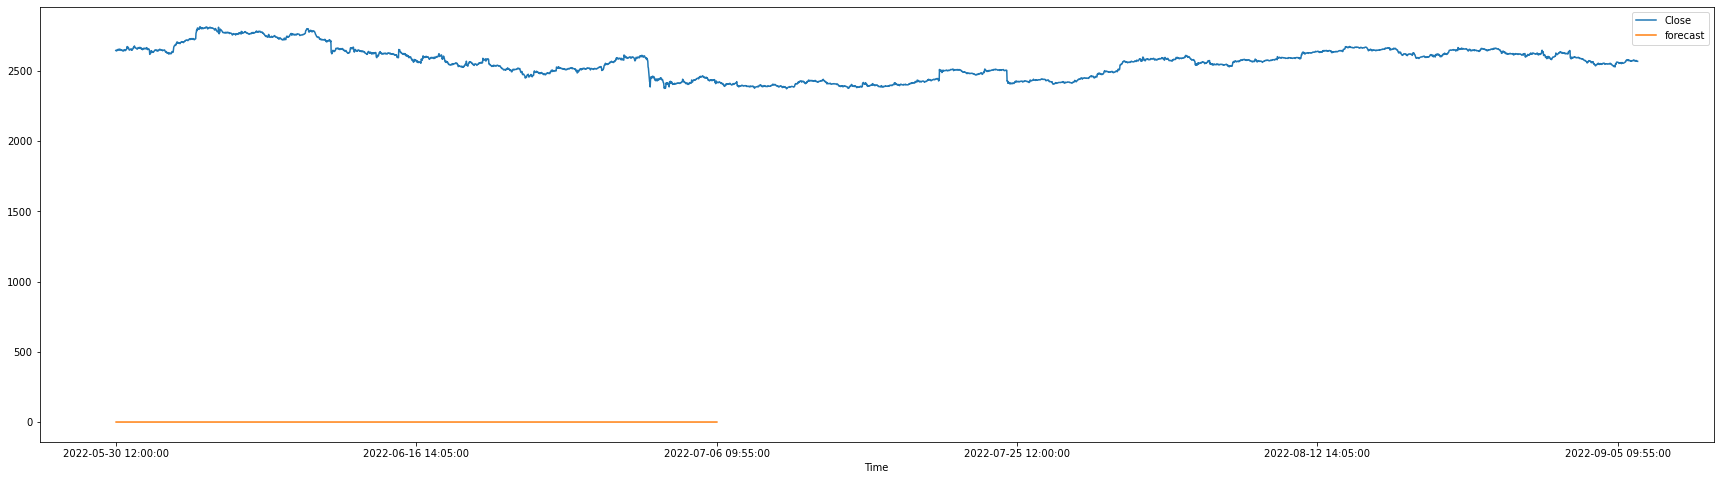

In [20]:
df['forecast']=results.predict(start=pred_start_date,end=pred_end_date,dynamic=True)
df['forecast']=df['forecast'].shift(1)
df[['Close','forecast']].plot(figsize=(30,8))